## Set up Environment and Modules

In [1]:
# print all output in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# set filterwarnings to 'once' to show warnings only the first time code is run
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import modules
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import json
from pathlib import Path

# import plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

_=sns.set_style(style = 'dark')
_=sns.set_context("talk")

#print(plt.style.available)

# set displaying options for plots with sns and plt
_=plt.rcParams['figure.figsize'] = [14,6]

# 'double resolution plot output for Retina screens'
%config InlineBackend.figure_format = 'retina'


In [4]:
# add custom functions to the path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# set path to save data, save images, retrieve code
data_path = Path("../data/")
img_path = Path('../images/')

# User Logins

## Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [5]:
# read the logs
def read_logs(file_path, col, sample = False):
    rawData = pd.read_json(file_path)
    sampled_df = rawData.resample(sample, label='right', on = col).agg('count')
    print('The log contains %d records'%rawData.shape[0])
    sampled_logs = sampled_df.stack().reset_index()
    # rename the count column
    sampled_logs = sampled_logs.rename(columns={0:'count'})
    return sampled_logs

In [6]:
sampled_logs = read_logs('logins.json', col = 'login_time', sample = '15T')
sampled_logs.head()

The log contains 93142 records


,login_time,level_1,count
0,1970-01-01 20:15:00,login_time,2
1,1970-01-01 20:30:00,login_time,6
2,1970-01-01 20:45:00,login_time,9
3,1970-01-01 21:00:00,login_time,7
4,1970-01-01 21:15:00,login_time,1


In [7]:
# import bokeh modules
from bokeh.io import output_notebook, output_file, show, export_png
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Range1d, DataRange1d, Plot, CategoricalColorMapper, LabelSet, BoxAnnotation
from bokeh.models.tools import HoverTool
from bokeh.models.glyphs import Circle, Text
from bokeh.palettes import Spectral5
from bokeh.transform import factor_cmap
from bokeh.models.annotations import Label

output_notebook()

Loading BokehJS ...

In [8]:
# create features from the login times
sampled_logs['year'] = sampled_logs.login_time.dt.year
sampled_logs['day_of_week'] = sampled_logs.login_time.dt.dayofweek
sampled_logs['day'] = sampled_logs.login_time.dt.day
sampled_logs['hour'] = sampled_logs.login_time.dt.hour
sampled_logs['minute'] = sampled_logs.login_time.dt.minute
sampled_logs['time'] = sampled_logs.login_time.dt.time
sampled_logs['date'] = sampled_logs.login_time.dt.date
sampled_logs.head()

,login_time,level_1,count,year,day_of_week,day,hour,minute,time,date
0,1970-01-01 20:15:00,login_time,2,1970,3,1,20,15,20:15:00,1970-01-01
1,1970-01-01 20:30:00,login_time,6,1970,3,1,20,30,20:30:00,1970-01-01
2,1970-01-01 20:45:00,login_time,9,1970,3,1,20,45,20:45:00,1970-01-01
3,1970-01-01 21:00:00,login_time,7,1970,3,1,21,0,21:00:00,1970-01-01
4,1970-01-01 21:15:00,login_time,1,1970,3,1,21,15,21:15:00,1970-01-01


In [9]:
from src.visualize import plot_LogsOvertime

### Logs over time

The following graphs show logins over time. The first graph shows a spike in logins in March. A closer look shows a single day had over 70 logins, making it an out of the ordinary event, since based on the average, April has a greater average, as shown the second plot below.

In [10]:
# plot log ins over time
plot_LogsOvertime(sampled_logs, col1='login_time',
                  col2='count',title = 'Logs over time',
                  x_label='Login date and time', y_label='Count')

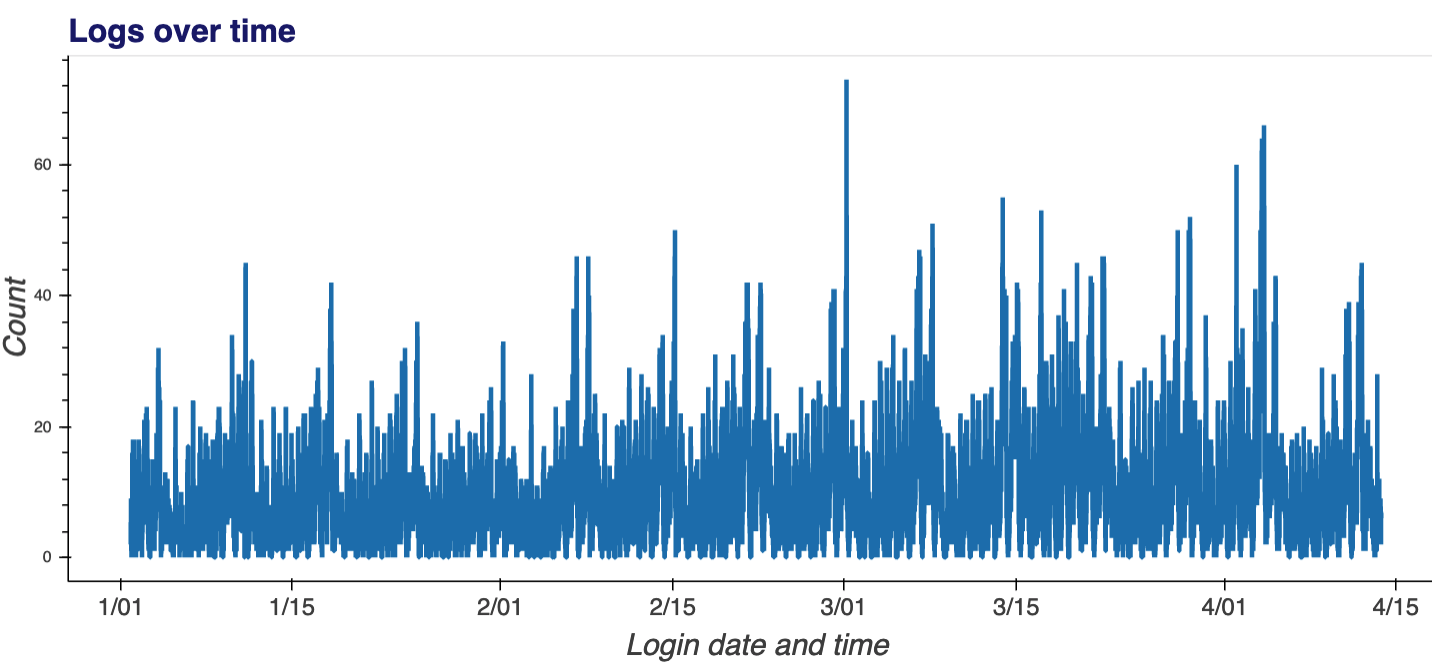

In [11]:
###### change to code cell when running in interactive mode outside github

# <img src= "../images/LogsOverTime.png"/> markdown

from IPython.core.display import Image, display
display(Image(filename="../images/LogsOverTime.png"))

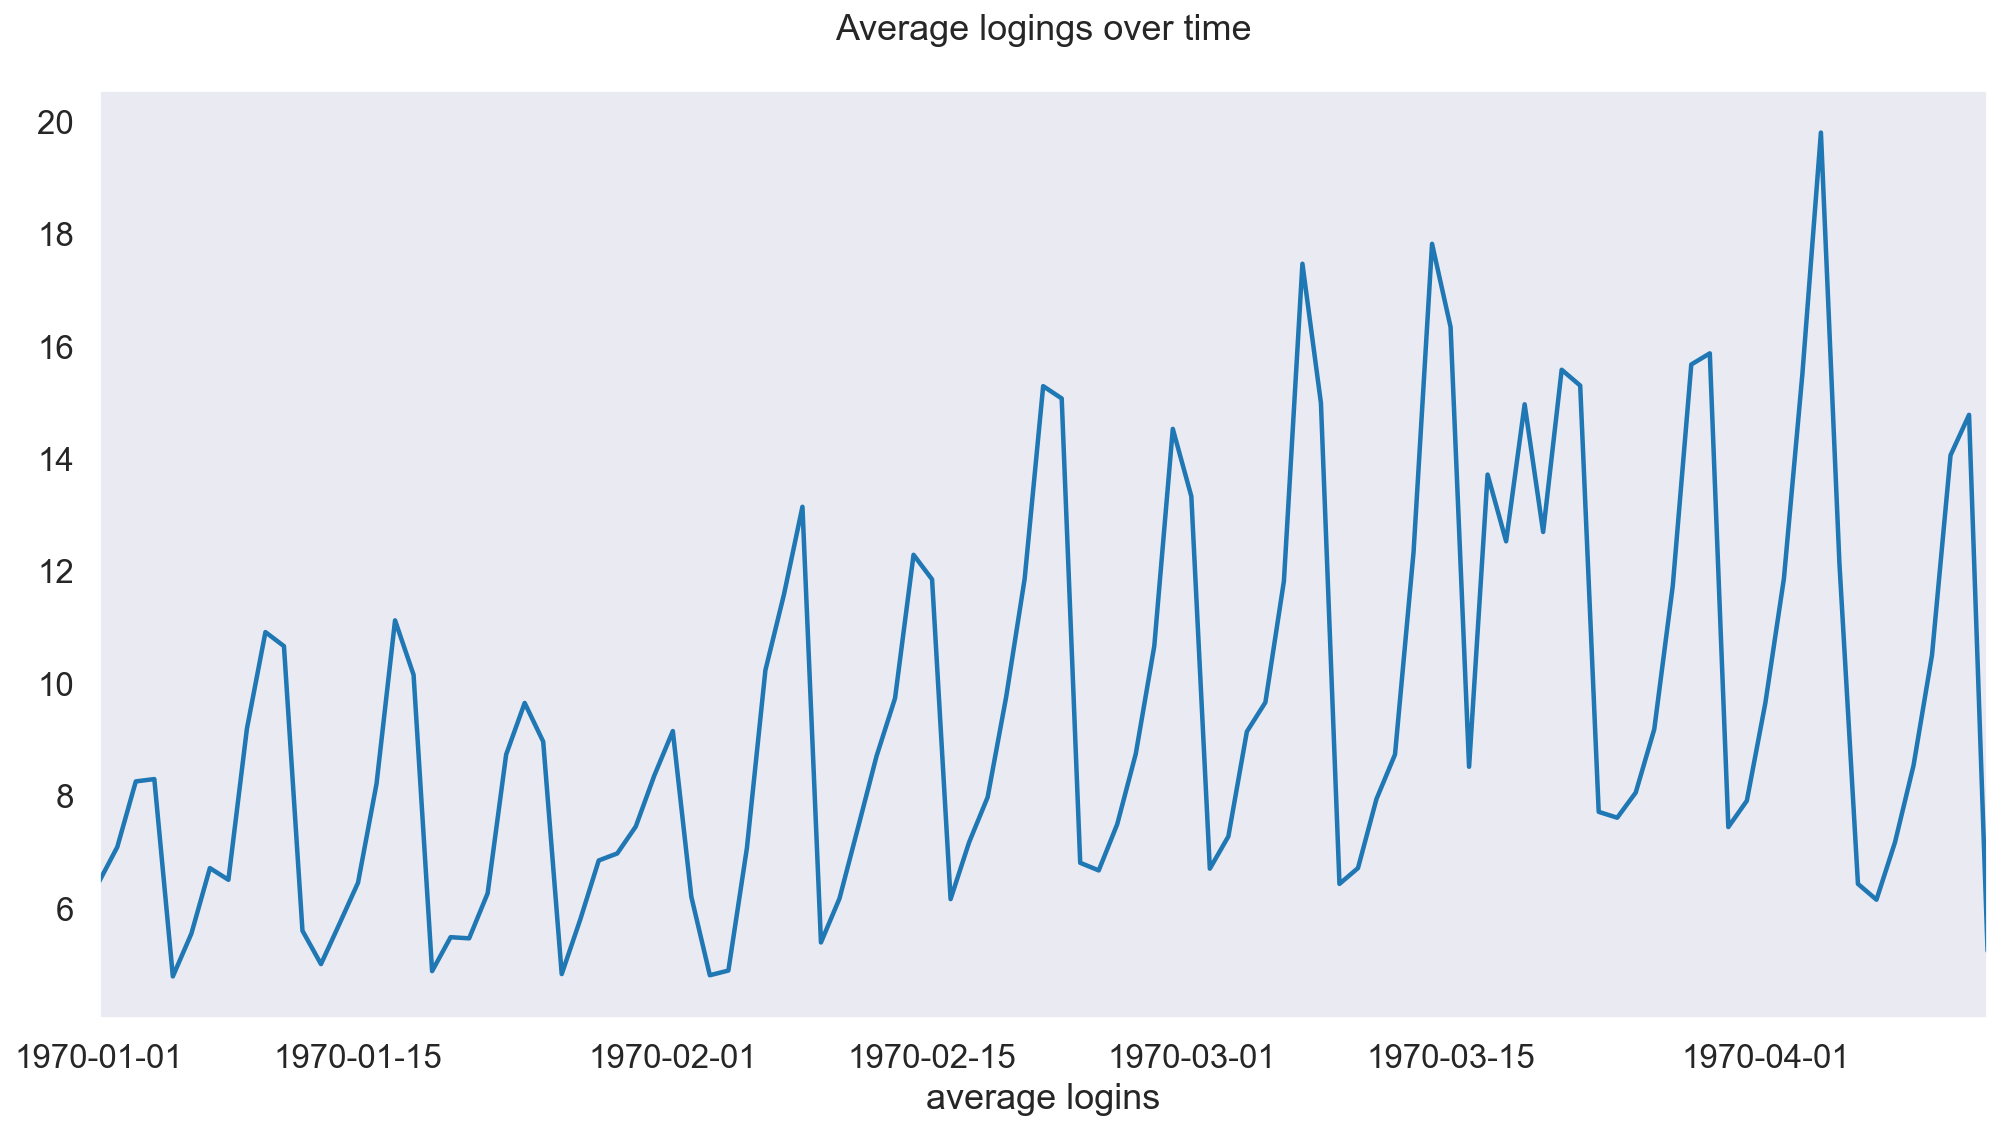

In [12]:
# plot average number of logins by date

_=plt.figure(figsize=(14,8))
_=sampled_logs.groupby('date')['count'].mean().plot(title = 'Average logings over time\n')
_= plt.xlabel('average logins')
plt.tight_layout()

#### Fridays have the largest numbers of logins.

Comparing logins by weekday, shows that Fridays are the most popular/busy days. Logins progressively increase during the week, starting on Thursdays, peaking on Fridays and slowly declining on Sunday. The graph shows, in total there over 19,000 logins were recorded on Friday.

In [13]:
plot_LogsOvertime(sampled_logs, col1='day_of_week',
                  col2='count',title = 'Logs over time',
                  x_label='Login day of the week (sunday=0, friday=5)', 
                  y_label='Count', 
                  tooltips = [('count', '@count'), ('day_of_week', '@day_of_week')]
                 )

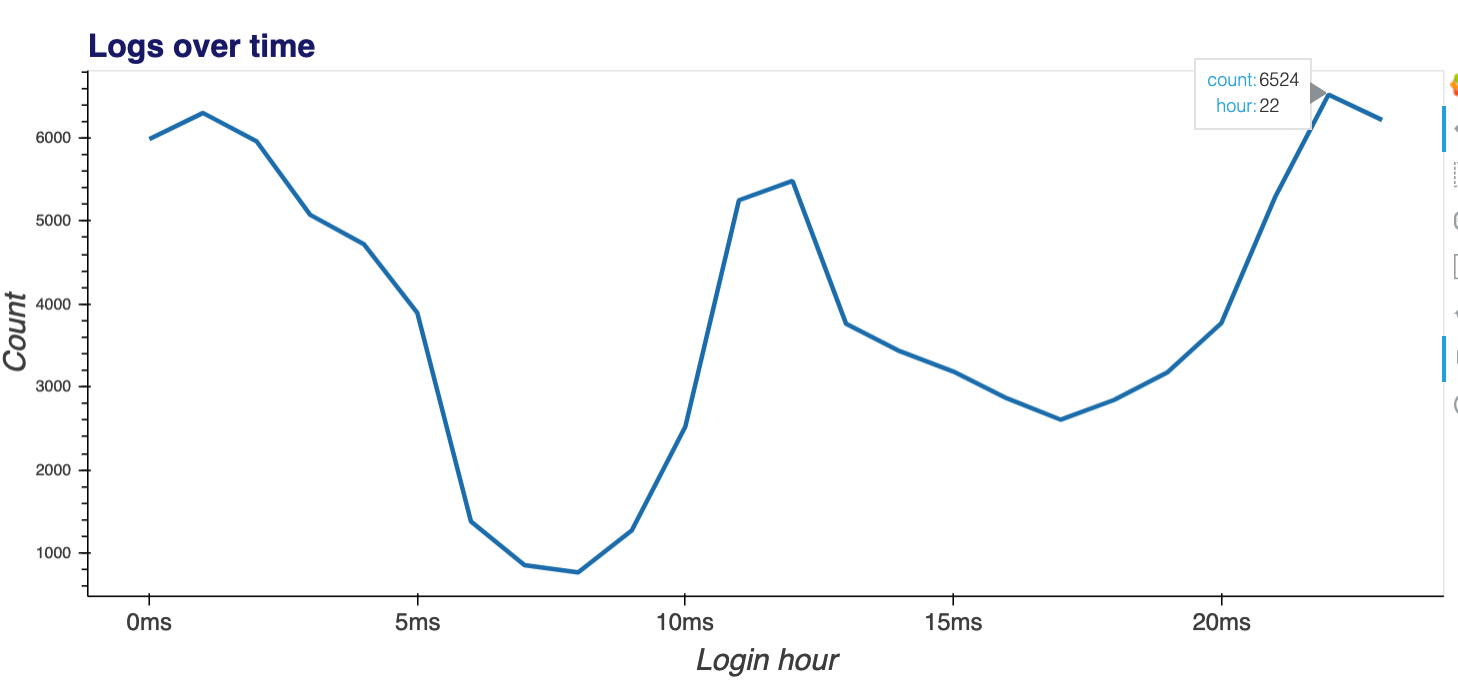

In [14]:
###### change to code cell when running in interactive mode outside github
# <img src= "../images/LogOverWeekday.png"/> # mardown
from IPython.core.display import Image, display
display(Image(filename="../images/LogsOverHour.png"))

### Busiest times.

Although the data shows that noon and after 7:00 pm there is an increase in the number of logins, it is not clear only from this data that these are the times when customers logged in as there is no mention of the user's time zone.

In [15]:
plot_LogsOvertime(sampled_logs, col1='hour',
                  col2='count',title = 'Logs over time',
                  x_label='Login hour', 
                  y_label='Count',
                 tooltips = [('count', '@count'), ('hour', '@hour')])

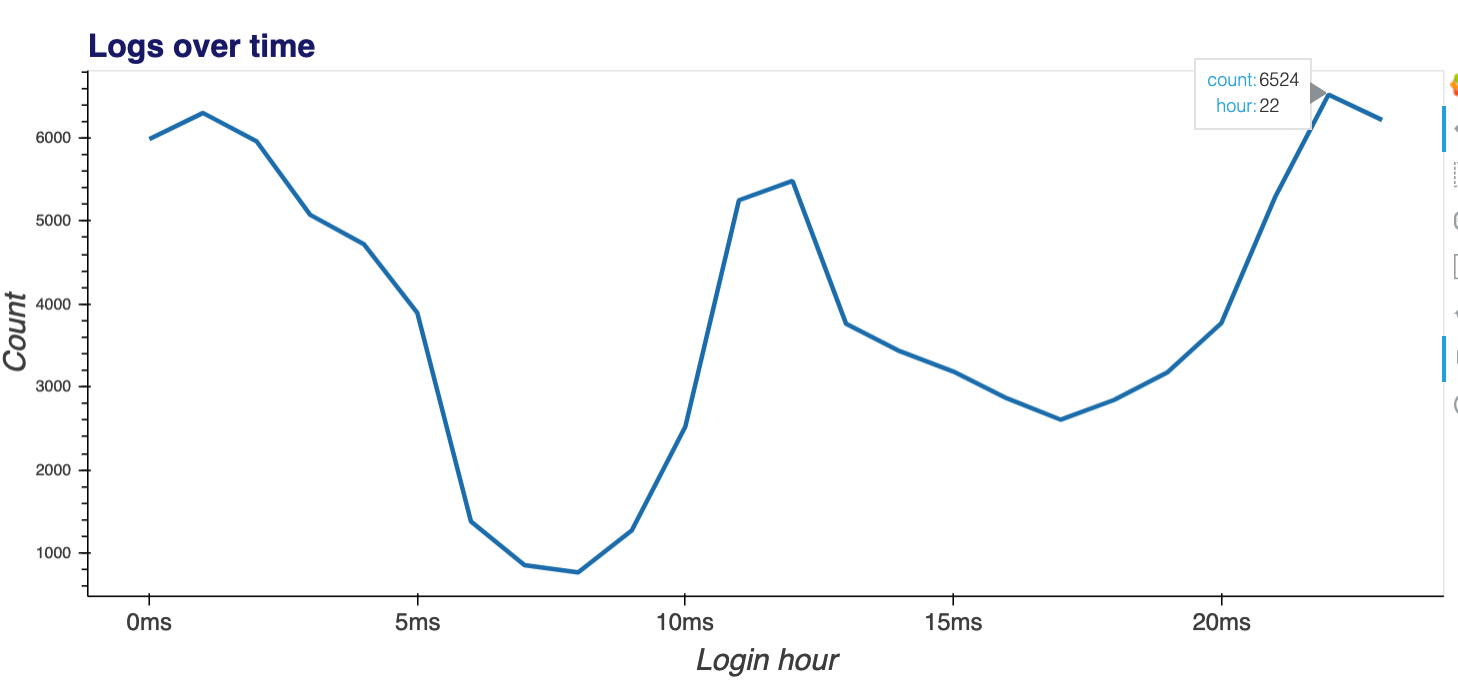

In [16]:
###### change to code cell when running in interactive mode outside github
#<img src= "../images/LogsOverHour.png"/> markdown

from IPython.core.display import Image, display
display(Image(filename="../images/LogsOverHour.png"))

***
# Ridership between cities

## Experiment and metrics design

<p>The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.</p>

<p>However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.<p>
    
<ol>
    
<li> What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?</li>

<p>A key measure of success will be an increase in the number of driver partners' cars crossing the toll and the time between trips. By recording this data, along with the cars' tag numbers, crossing times, day of the week, and speed via the toll tags, the cities can help determine in which city the program is being more successful and the best days to implement the program. For instance, it can help identify if drivers of one city are using the program more and if the drivers are staying in the other cities during peak hours, work hours, or  weeknights.</p>

<p>
<li>Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:</li>

    a. how you will implement the experiment
    
    One way is to record the cars' tag numbers to help identify their city, crossing times, day of the week, and speed via the toll tags for two to three months. Then, compare this data with historical data from three months prior the announcement of the reimbursement program.
    
    b. From here two different t-test can be applied:
    
    * one to uncover if there is statistically significant change in the average number of driver partner cars crossing the tolls.
    * two, compare if there is a statistically significant difference between the number of drivers from one city compare to the other considering the reimbursement is the same.
    
    c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.
    
    The tests will allow to see which drivers are more engaged in the program, the times with more demand based on the times recorded by the toll. The recommendation will allow managers decide if the increase in drivers is helping the other city by creating more ride options for the citizens or if the measure is hurting the city by increasing traffic and congestion.
</ol>
</p>

***
***


# Ridership Predictive modeling

<p>Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014.</p> 

<p>The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.</p>

<p>The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.</p>

<ol>
    
<li>Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?</li>

<li>Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.</li>

In [17]:
# read the logs
def read_Ridersjson(file_path):
    data = json.load(open(file_path))
    df = json_normalize(data)
    print('The dataset is a collection of %d ridership statistics for %d riders.'%(df.shape[1],df.shape[0]))
    return df

In [18]:
retention = read_Ridersjson('ultimate_data_challenge.json')
retention.head()

The dataset is a collection of 12 ridership statistics for 50000 riders.


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [19]:
# percentage of missing records
(retention.isna().sum()/len(retention)) * 100

avg_dist                   0.000
avg_rating_by_driver       0.402
avg_rating_of_driver      16.244
avg_surge                  0.000
city                       0.000
last_trip_date             0.000
phone                      0.792
signup_date                0.000
surge_pct                  0.000
trips_in_first_30_days     0.000
ultimate_black_user        0.000
weekday_pct                0.000
dtype: float64

In [20]:
retention[retention['avg_rating_of_driver'].isnull()].head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
6,3.95,4.0,NaN,1.0,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0
9,2.37,5.0,NaN,1.0,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0
12,20.29,5.0,NaN,1.0,Winterfell,2014-03-12,iPhone,2014-01-15,0.0,1,False,100.0
14,26.01,5.0,NaN,1.0,Astapor,2014-01-28,Android,2014-01-27,0.0,1,False,100.0
15,13.20,5.0,NaN,1.0,Winterfell,2014-01-16,Android,2014-01-15,0.0,1,True,100.0


In [21]:
retention['avg_rating_of_driver']=retention['avg_rating_of_driver'].fillna(retention['avg_rating_of_driver'].mean())

In [22]:
retention.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.564977,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.500000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.700000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [23]:
[set(retention['city'])]
[set(retention['phone'])]

[{'Astapor', "King's Landing", 'Winterfell'}]

[{'Android', None, 'iPhone'}]

## No difference in average rating of driver between cities

A comparison of the average rating of drivers between cities shows that although there is slightly more below average ratings in Winterfell, the difference is not substantial.

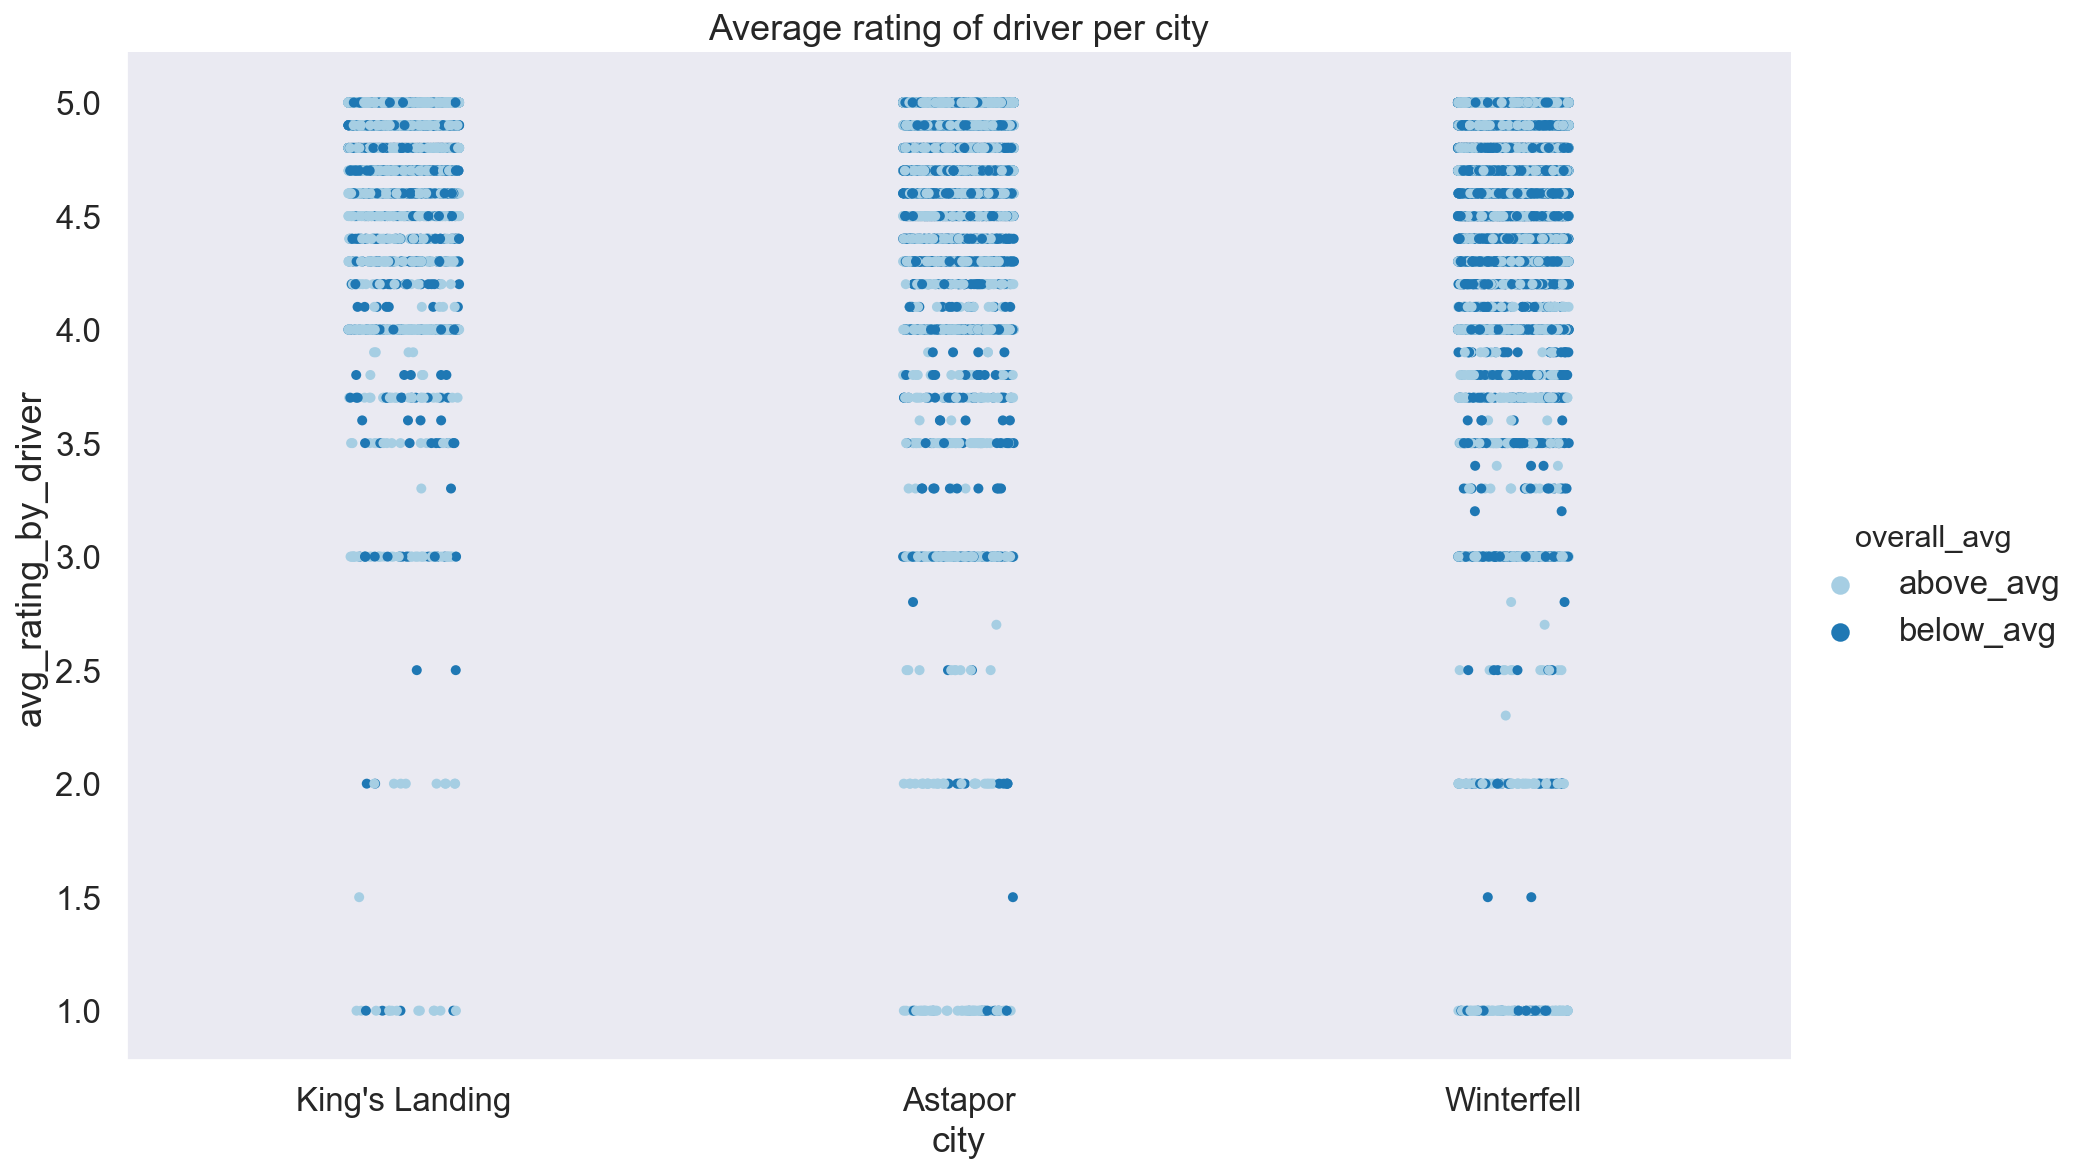

In [24]:
_=plt.rcParams['figure.figsize'] = [14,8]
_=retention['overall_avg'] = ['above_avg' if x > 4.6 else 'below_avg' for x in retention['avg_rating_of_driver']]

_= sns.catplot(x='city', 
               y = 'avg_rating_by_driver', 
               data=retention, 
               color = '#43a2ca',
               palette='Paired',
               legend_out=True, aspect= 1.6, height=8,
               hue = 'overall_avg')
_=plt.title('Average rating of driver per city')

# Retention
In order to know which users are still using the service and find patterns among riders who use the service more often and those who are not active, a new feature was created using the sign up date and the last date of use.

In [25]:
retention['signup_date'] = pd.to_datetime(retention['signup_date'])

retention['last_trip_date'] = pd.to_datetime(retention['last_trip_date'])

retention['membership_duration'] = (retention['last_trip_date'] - retention['signup_date']).dt.days

In [26]:
retention['retained'] = retention['trips_in_first_30_days'].apply(lambda x: True if x>0 else False)
retention.head(3)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,overall_avg,membership_duration,retained
0,3.67,5.0,4.7,1.1,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,above_avg,143,True
1,8.26,5.0,5.0,1.0,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,above_avg,96,False
2,0.77,5.0,4.3,1.0,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,below_avg,1,True


proportion of retained users 0.692200


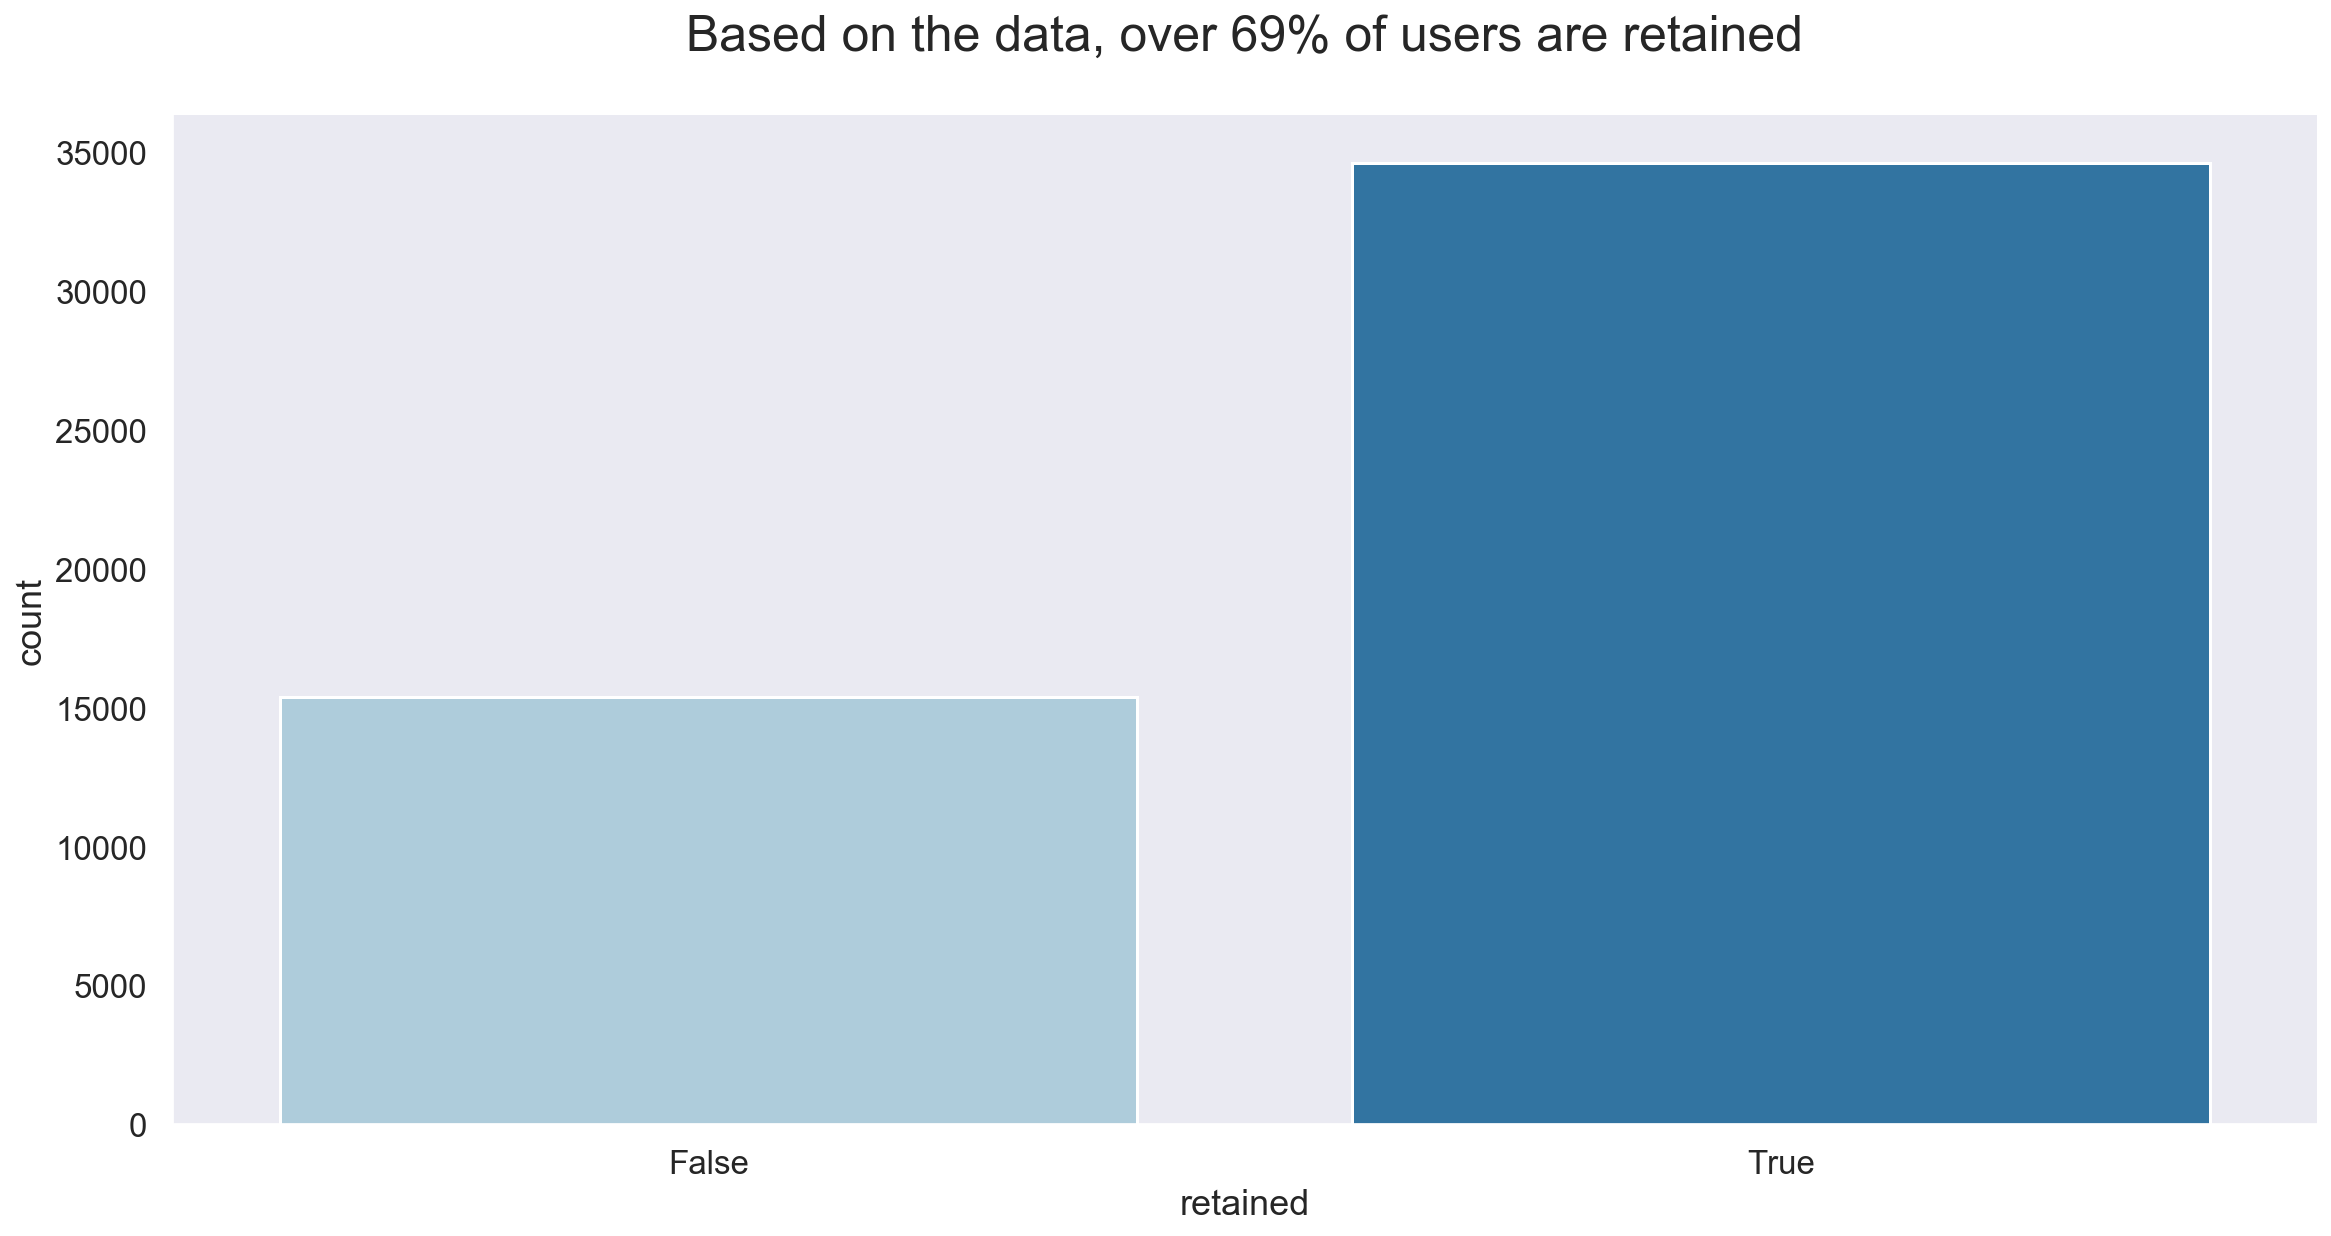

In [27]:
_=sns.catplot('retained', 
              data = retention, 
              kind = 'count', 
              height=8, aspect=2, 
              palette='Paired')
_=plt.title('Based on the data, over 69% of users are retained\n', 
            fontdict= {'fontsize': 25})

print ('proportion of retained users %2f'%(np.sum(retention['retained'])/len(retention)))

Based on the description of 'active' or retained users, the number of users that were retained is equivalent to the riders who have more than one ride in the first 30 days. Hence, a new feature was created based on the data recorded under the <em>"trips_in_first_30_days".</em>

# Modeling

<p>The following section focuses on creating a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system.</p>

<p>Since we want to find the factors that have an impact on ridership and determine whether a user will remain a customer, we need a model that provides the feature importance and avoid 'black box' algorithms. Hence a random forest will be trained using all the features as predictors.</p>

<p>Since the target of the predictive model is to determine whether or not a user will be active in their 6th month on the system. The target variable is created using the 6th month mark from the first day of sign up.</p>

In [28]:
# create target using the 6th month mark from the first day of sign up.
retention['target'] = (retention.last_trip_date>='2014-06-01')

In [29]:
# create dummy variablesfor categorical variables
df = pd.concat([retention,pd.get_dummies(retention[['phone', 'city']], 
                                   prefix=['is', 'is'],
                                   drop_first=False)] ,axis=1)
df.reset_index(inplace=True)

In [30]:
# create dummy variables for boolean variables
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

df['black_user_code'] = encoder.fit_transform(df['ultimate_black_user'])

In [31]:
df.columns

Index(['index', 'avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',
       'avg_surge', 'city', 'last_trip_date', 'phone', 'signup_date',
       'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user',
       'weekday_pct', 'overall_avg', 'membership_duration', 'retained',
       'target', 'is_Android', 'is_iPhone', 'is_Astapor', 'is_King's Landing',
       'is_Winterfell', 'black_user_code'],
      dtype='object')

## Fit Random Forest model

In [32]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report

In [33]:
# split the data
from sklearn.model_selection import train_test_split

X = df[['avg_dist','avg_rating_of_driver','avg_surge',
        'surge_pct', 'trips_in_first_30_days',
       'weekday_pct','is_Android', 'is_iPhone', 'is_Astapor', 
        "is_King's Landing",'is_Winterfell', 'black_user_code']]

y = df['target']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state = 44)


In [34]:
np.random.seed(44)

#Create Classifier
rf=RandomForestClassifier(n_estimators=200, random_state=44)

#Train the model using the training sets y_pred=clf.predict(X_test)
_=rf.fit(Xtrain,ytrain)

pred_rf=rf.predict(Xtest)

### Test the model

In [35]:
print("Accuracy score Random Forest:",metrics.accuracy_score(ytest, pred_rf))
print('\nClassification Report Random Forest')
print(classification_report(ytest, pred_rf))

Accuracy score Random Forest: 0.7464666666666666

Classification Report Random Forest
              precision    recall  f1-score   support

       False       0.80      0.80      0.80      9359
        True       0.66      0.66      0.66      5641

    accuracy                           0.75     15000
   macro avg       0.73      0.73      0.73     15000
weighted avg       0.75      0.75      0.75     15000



The model performed fairly well, obtaining a 75% accuracy on unseen data. The random forest was able to identify 75% of the variance in customers retention beyond the 6th month mark. It accurately identified 66% of customers who remain active after 6 months.

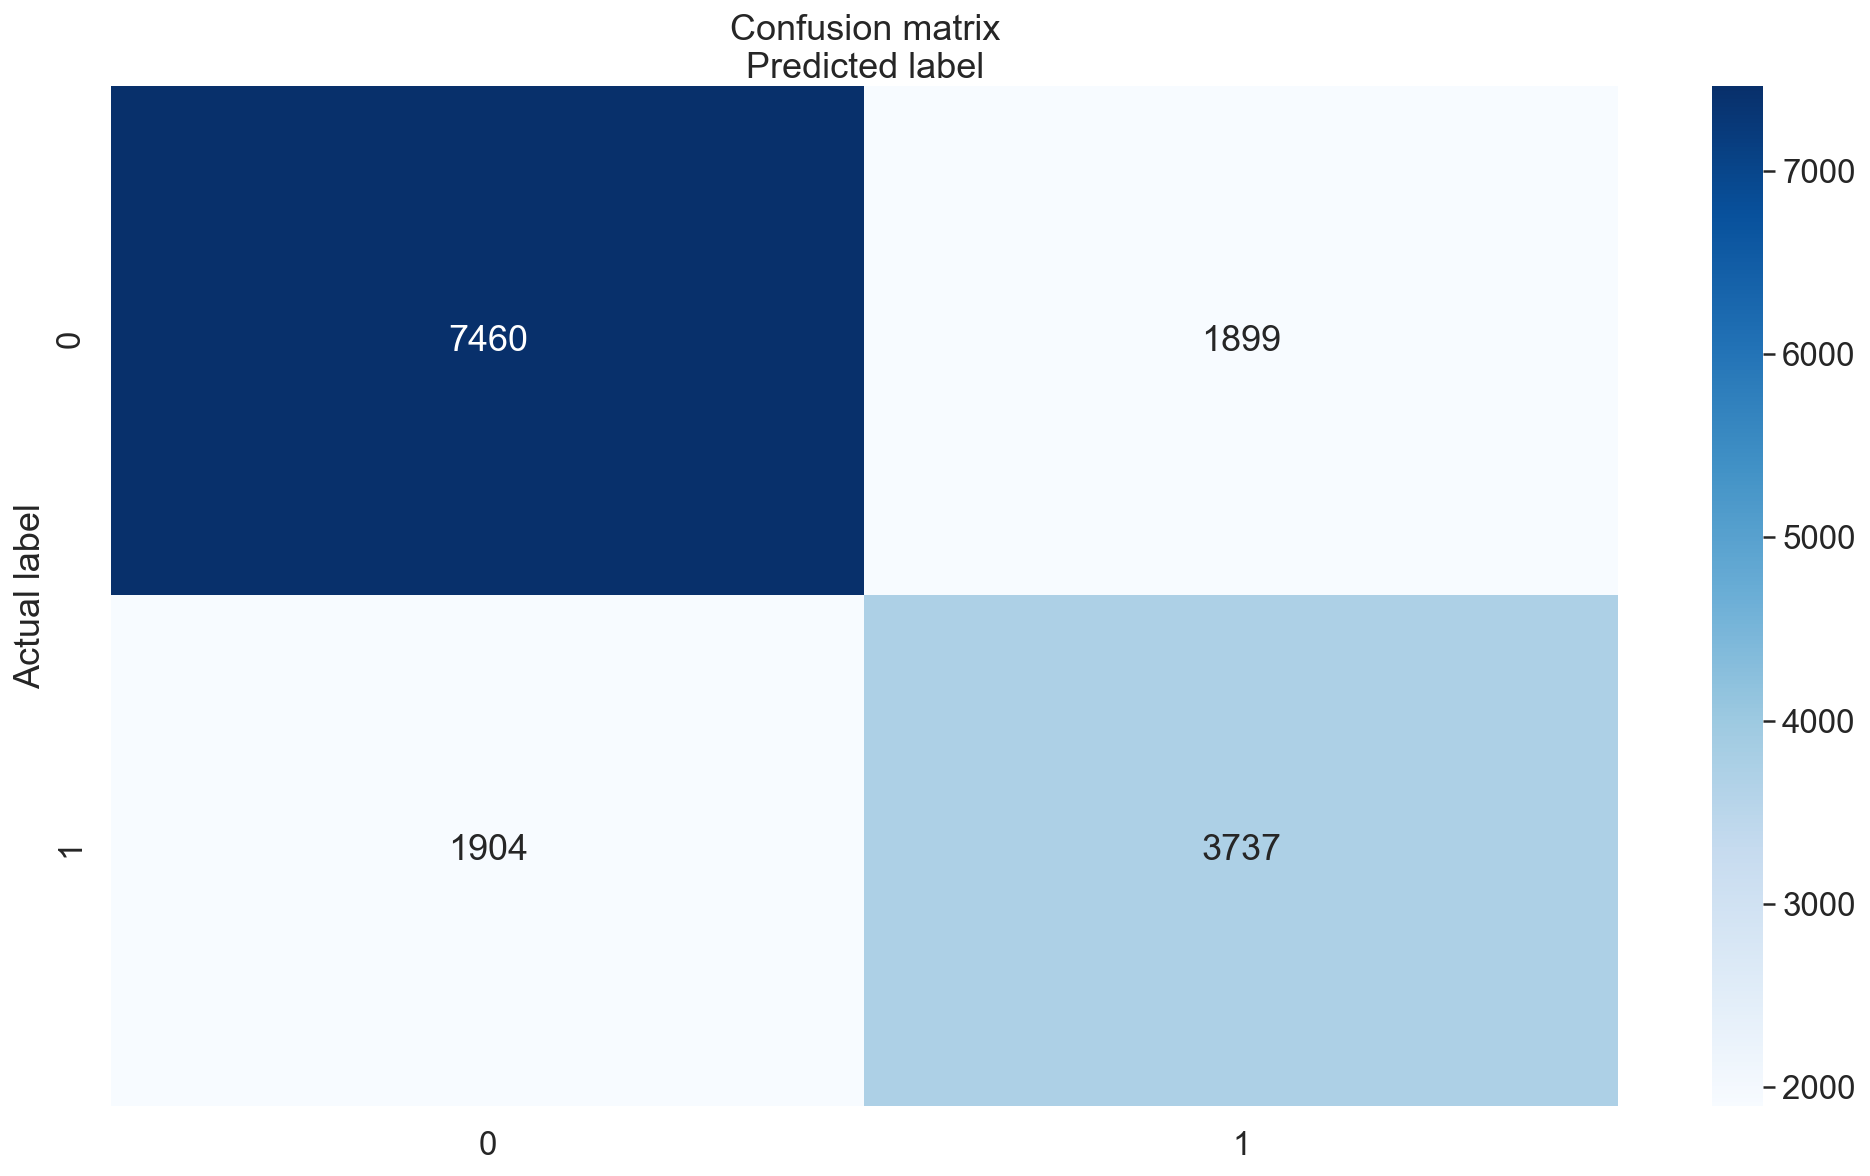

In [36]:
# test accuracy using confusion matrix
cnf_matrix = metrics.confusion_matrix(ytest, pred_rf)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
_=plt.xticks(tick_marks, class_names)
_=plt.yticks(tick_marks, class_names)
sns.set_context("notebook", font_scale=1.5)

# create heatmap
_=sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='Blues' ,fmt='g')
_=ax.xaxis.set_label_position("top")
_=plt.tight_layout()
_=plt.title('Confusion matrix', y=1.1)
_=plt.ylabel('Actual label')
_=plt.xlabel('Predicted label')

## Feature importance

The algorithm identified the average distance in miles per trip taken in the first 30 days after signup as the most important factor to identify whether a customer will remain active after six months. The percent of the user’s trips occurring during a weekday was identified as the second most important factor.

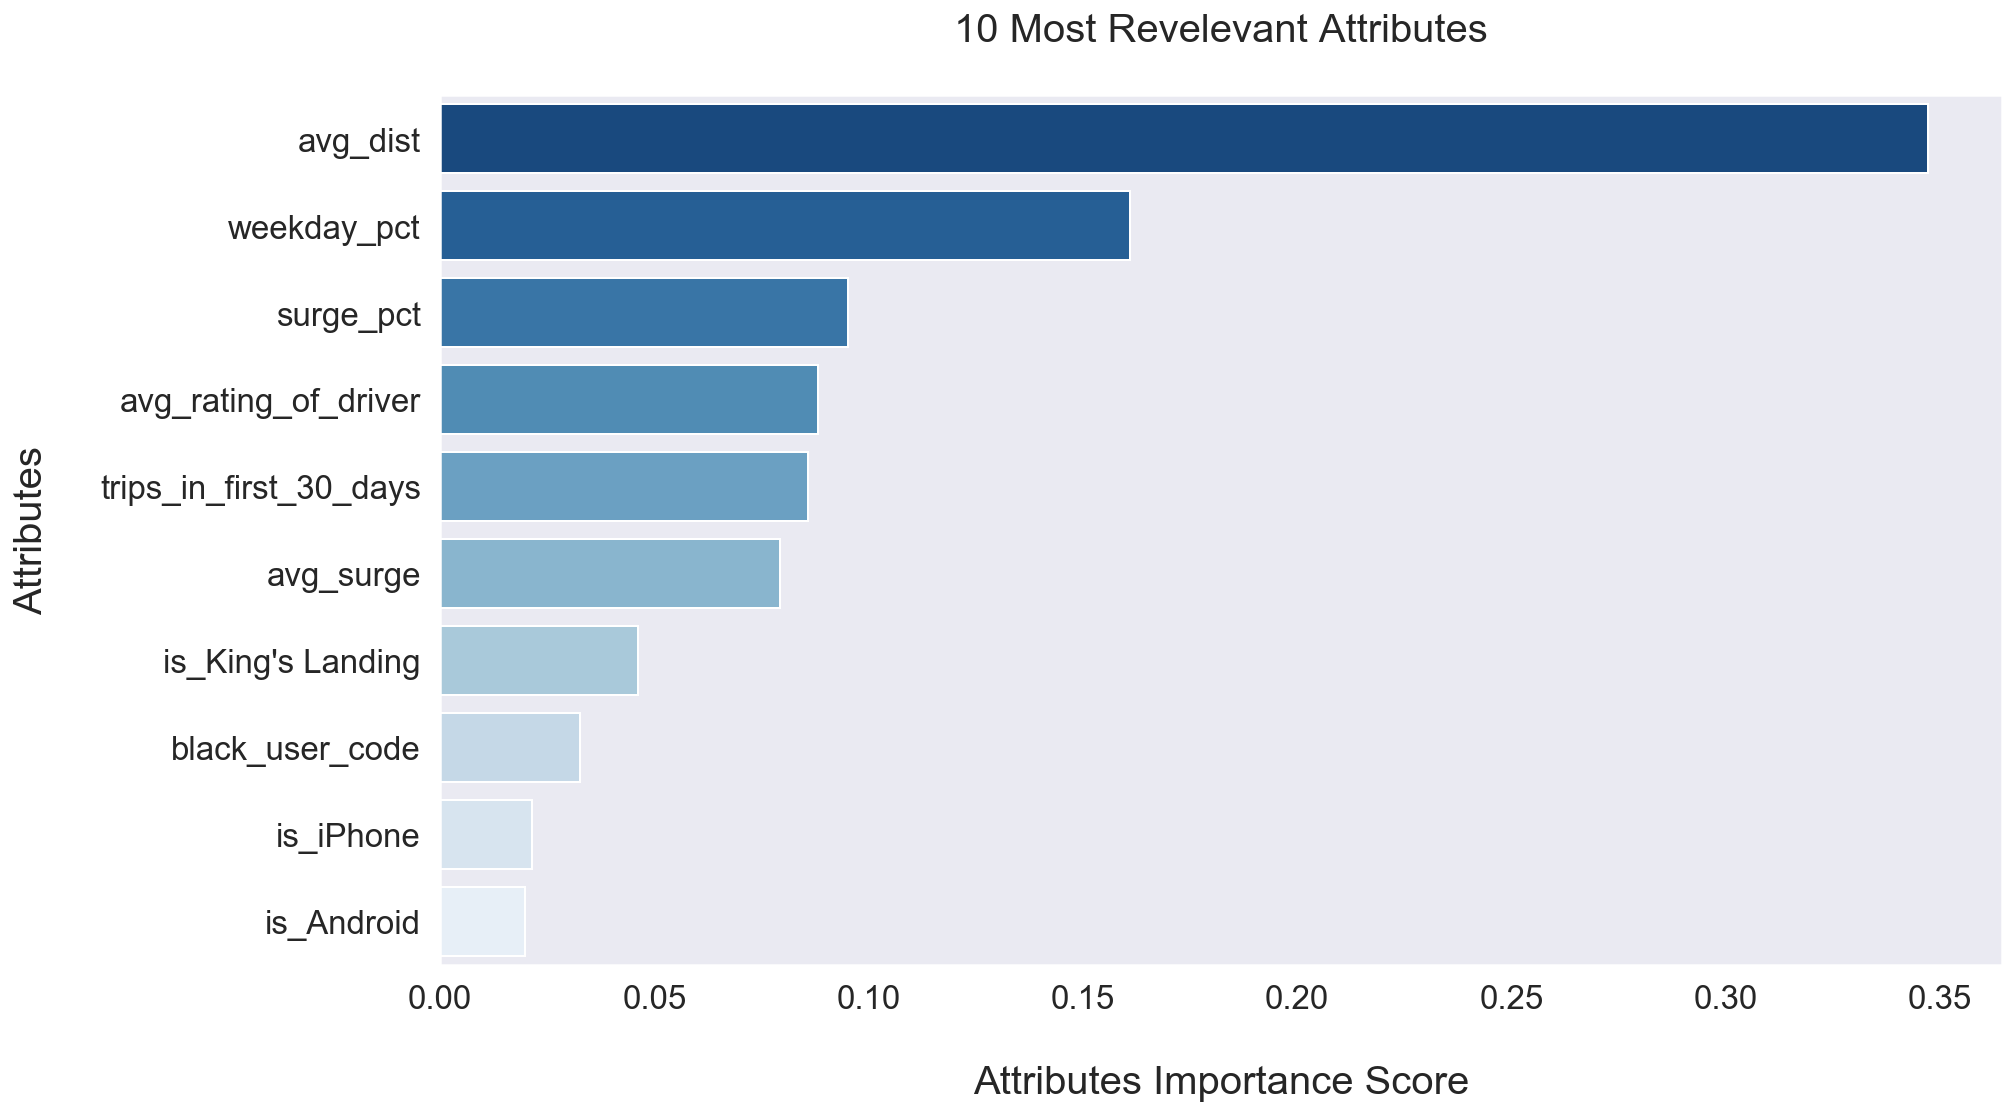

In [37]:
# set random seed to replicate results
np.random.seed(44)

# get variable names
model_vars = X.columns.to_list()

# create a data frame with variables importance and their score
feature_imp = pd.Series(rf.feature_importances_,index=model_vars).sort_values(ascending=False)

# plot 10 most relevant variables
_=sns.barplot(x=feature_imp[:10], y=feature_imp.index[:10], palette='Blues_r')
_=plt.title('10 Most Revelevant Attributes\n', fontsize = 20)
_=plt.xlabel('\nAttributes Importance Score', fontsize = 20)
_=plt.ylabel('Attributes\n', fontsize = 20)

## Leveraging the insights from the model
Since average distance and the percentage of trips during the weekday are among the most important factors, the company can provide incentives to riders who use the service during the week, by providing a night credit during the weekend for every five weekdays.
The company can also provide credit to new customers that have rides longer than 10 miles.